# Patent applications analysis

This notebook provides different statistics related to patent applications. **It is important to note that all the given numbers refers to granted patents approved by the USPTO (United State Patent and Trademark Office)**. Therefore the statistics highlighted do not cover all the patent applications all over the world, but since the US is the most important patent provider, our study gives an accurate overview of the trend in the world.


Our research aims to compare the evolution of patents application according to different countries, sectors, companies. Thus, the absolute number of patents is less relevent than its evolution over time.

This notebook includes the following studies :

    1) The evolution of granted patents around the world the past 10 years (from 2007 to 2017)
    2) The number of USPTO granted patent by countries
    3) A colorful map highlighting the dispertion of patents around the world
    4) The top companies delivering patents 
    5) The top countries delivering patents by general sectors in CPC (Cooperative Patent Classification)
    7) Spider charts for the top patents delivered countries displaying the popular sectors
    6) A study of the number of patents delivered for a specific sector (To be continued for the next milestone) 

**Important:** In order to keep the notebook shorter and more to the point, the core implementation is contained in the python file **implementations.py**, which carefully and thouroughly describes the purpose of each function. We kindly invite you to have a look at it. We will however give a brief description of what a functions does when it is first used.

In [1]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


The file **implementations.py** contains the definitions of the functions used throughout the notebook.

In [2]:
from implementations import *

In order to manipulate the database, an API is provided. The latter will allow us to send queries which always start with the following base URL **BASE_URL 'http://www.patentsview.org/api/patents/query?'**

In ***implementations.py***, the function BASE_URL() returns this base URL as a helper function. 

It is possible to request a specific research by keywords.
For exemple we could search (using q) for all the patents granted since April 2007 and display the patent number and patent granted date (using f):

      Example : 
#### http://www.patentsview.org/api/patents/query?q={"_gte":{"patent_date":"2007-01-04"}}&f=["patent_number","patent_date"]

### Number of granted patents over the past 10 years

This section aims to display the evolution of granted patent from January 2007 to January 2017

The API cannot return more than 100000 patents in one request. Thus, we need to collect the number of patents by months first and then aggregate the results to obtain the number of patents over a year.

Let's display the number of granted patents in a table. We use **get_nb_patents_year** to get the number of granted patent for a given year (12 months).

In [24]:
years = list(range(2007,2017))
list_nb_patent=[get_nb_patents_year(str(year)) for year in years]
df_nb_patent=pd.DataFrame(index=years)
df_nb_patent['nb_patents']=list_nb_patent
df_nb_patent

,nb_patents
2007,183496
2008,181694
2009,190319
2010,245132
2011,246696
2012,275227
2013,296921
2014,326920
2015,324822
2016,340823


In [25]:
savedfexcel(df_nb_patent ,'df_nb_patents')
dfNbPatent=pd.read_excel('evolution_nb_patents.xlsx')

We can plot the numbers to have a better visualization of the number of granted patent.

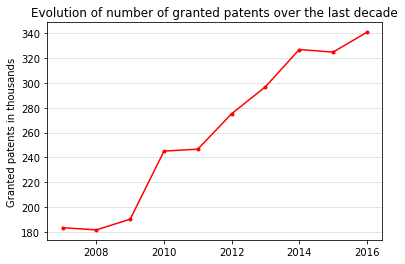

In [26]:
plot(years, df_nb_patent['nb_patents']/1000, 'r', marker= '.')
plt.ylabel('Granted patents in thousands')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Evolution of number of granted patents over the last decade")
plt.show()

### Number of granted patent delivered by countries

This section aims to display which countries are the top patent providers. In a given patent, multiple inventors might be cited. Those inventors can be located in different countries. In that case, +1 will be counted for a country if at least one of the inventor is in the given country. The number of patents between January 2016 and January 2017 was chosen for this study.

First, we read the excel file **location.xlsx** given by the USPTO website which contains all the countries which have delivered patents in the past. The country names are coded according to the Alpha-2 ISO norm ("US","GE","FR","CH",...)

In [27]:
dfLocation=pd.read_excel(os.getcwd()+'/data/location.xlsx').fillna('')

We clean the countries list and keep the Alpha-2 ISO codes only 

In [28]:
countries=list(set(list(dfLocation['country'])))
countries = [countries[i] for i in range(len(countries)) if (len(countries[i]) == 2 and countries[i]!='a"')]

The **get_nb_patent_country** function below returns the number of granted patents for a given country. It might be possible that some countries issue a large number of patents that exceeds 100'000 in the year which overwhelms the API capacity. In that case the API request is splited between the 6 first and 6 last months of the year, and the number of patents are summed up together. 

In [29]:
dfNbPatents=pd.DataFrame(columns=['country','nb_patents'])
dfNbPatents['country']=countries
dfNbPatents['nb_patents']=list(map(lambda x: get_nb_patent_country(x),dfNbPatents['country']))

We just created the dataframe containing the patents data grouped by countries.

The number of patents are sorted by country and the barplot is displayed. We chose to plot the 15 top countries

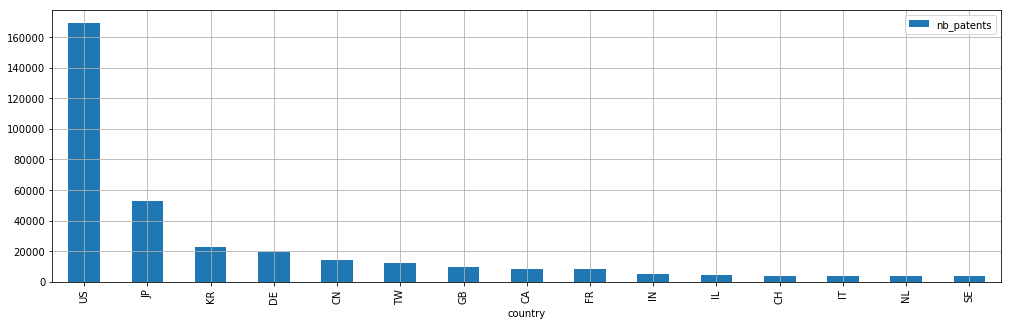

In [30]:
dfNbPatents.sort_values(by='nb_patents',inplace=True, ascending=False)
dfNbPatents.head(15).plot.bar(x='country', y='nb_patents', figsize=(17,5), grid=True)

Display the exact number for the 10 top patent delivered countries

In [31]:
dfNbPatents.set_index(pd.Series(list(range(1,len(dfNbPatents) + 1))), inplace=True)
dfNbPatents.head(10)

,country,nb_patents
1,US,169052
2,JP,53175
3,KR,22593
4,DE,19859
5,CN,14044
6,TW,12378
7,GB,9441
8,CA,8742
9,FR,8315
10,IN,5279


### Choropleth map map of the granted patent distribution around the world


This section aims to display a vizual world map that highlights the granted patent dispersion across the countries. 

As there is a very large gap between the number of patents throughout the different countries, we opted for a **logarithmic scale** for a better vizualisation. Without loss of generality, we shall still be able to vizualize accurate relative differences between numbers.   

In [32]:
# max_n is the maximum number of patents holder, which is the US
max_n = dfNbPatents['nb_patents'].max()
#Here, we set up a Colormap using the logarithmic scale as shades of Blue colors that will be used to color the map
colormap = cm.linear.PuBu.scale(0, round(math.log(max_n))).to_step(100)

In [33]:
patents = dfNbPatents.copy()
#Take the log of the number of granted patents to match the logarithmic scale
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , patents['nb_patents']))
#In the below DataFrame, each country has now its 'logarithmic color code'
patents['log_color_code'] = log_nb
patents.head()

,country,nb_patents,log_color_code
1,US,169052,12.037962
2,JP,53175,10.881344
3,KR,22593,10.025395
4,DE,19859,9.896413
5,CN,14044,9.549951


In [34]:
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = patents.set_index('country')['log_color_code']

#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

The function **ret_color** below, applies colors to the countries that were previously stored in **color_dict**.
In case a country does not appear in the list of patents, we assign the white color by default.

The JSON file **custom.geo.json** contains informations about the world countries. It is used to draw a Choropleth below.

We can now draw a chloropleth map that shows the number of patents around the world.

In [35]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = 'data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors using our defined function ret_color, desribed above
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('world.html')

Here is an overview of the distribution of granted patents over the world 

**The interactive map can be accessed [here](https://skagankose.github.io/ada_fall_2017/world.html).**

![Image](data/world_patent.png)

### GRANTED VS PENDING

Upon our initial milestone 2 objective, we wanted to compare how many patents application are granted. After digging deeper in the DataBase we found out that we can only obtain the granted patents. Therefore it will not be possible to carry out this comparison.

### TOP COMPANIES


This section aims to display the top companies patent publishers in the world. The function **get_company** below returns a dictionnary containing the companies as keys and their related number of patent application. 

To have a recent and significant number of patents we chose to analyse the patent applications over a recent period, namely here from the 1st of january 2017 to the 1st of may 2017. 

In [36]:
# DataFrame containing patent counts by companies
company_patent_df = pd.DataFrame(list(get_company(2017, 1, 2017, 5).items()))
# Cleaning NaNs
company_patent_df.dropna(inplace=True)
# Changing columns names
company_patent_df.columns = ['company', 'total_patent']
# Converting to integers
company_patent_df.total_patent = company_patent_df.total_patent.astype('int64', copy=False)
# Descending sort by number of granted patents
top_companies_df = company_patent_df.sort_values(by='total_patent', ascending=False)

Here is the list of the TOP15 world patent issuers companies, in terms of number of granted patents:

In [37]:
top_companies_df.head(15)

,company,total_patent
10,International Business Machines Corporation,111916
115,"Samsung Electronics Co., Ltd.",72139
639,Canon Kabushiki Kaisha,65779
785,Sony Corporation,47267
455,Kabushikikaisha Toshiba,46384
165,GENERAL ELECTRIC COMPANY,41692
1575,"Hitachi, Ltd.",38511
1298,Fujitsu Limited,33876
1555,Intel Corporation,33602
1941,Microsoft Corporation,29694


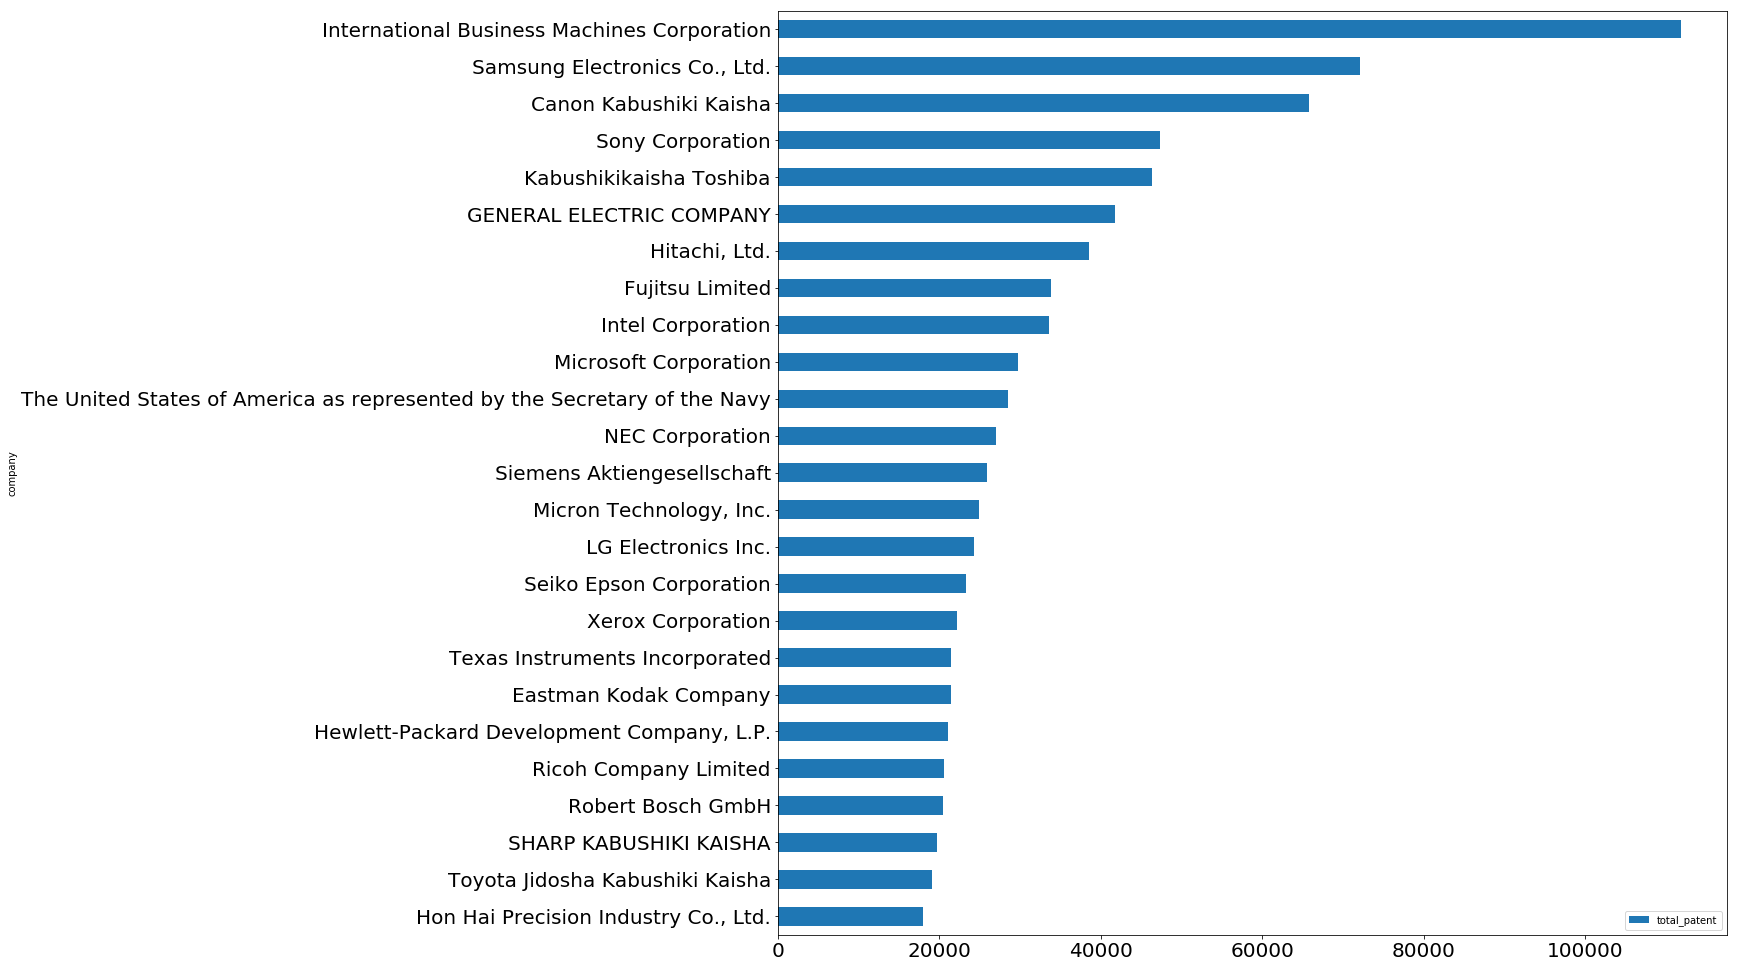

In [38]:
top_companies_df.head(25).plot.barh(x='company', y='total_patent', figsize=(17,17), fontsize=20).invert_yaxis()

As we can see **International Business Machines Corporation (IBM)** is the leader in terms of the number of granted patents by holding more than 120'000 patents, followed by Samsung Electronics (roughly 75'000) and Canon (75'000).

### Patents by countries and sectors

The Cooperative Patent Classification (CPC) is a patent classification system, which has been jointly developed by the European Patent Office (EPO) and the United States Patent and Trademark Office (USPTO).

Patent categories according to CPC are indicated in the following table. We've used these categories for our initial analysis. We assigned a code to every categories for a paractical purpose.

| **CODE** | **DESCRIPTION**   |
|------|------|
|   **A**  | **Human Necessities**|
|   **B**  | **Operations and Transport**|
|   **C**  | **Chemistry and Metallurgy**|
|   **D**  | **Textiles**|
|   **E**  | **Fixed Constructions**|
|   **F**  | **Mechanical Engineering**|
|   **G**  | **Physics**|
|   **H**  | **Electricity**|
|   **Y**  | **Emerging Cross-Sectional Technologies**|

First we obtain the Alpha-2 codes for each country by reading **countries.csv**, which is provided by the **USPTO website** and initialise a dictionnary. The latter countains every countries and the number of patents by categories

In [39]:
# # The following DataFrame contains the Alpha-2 ISO names of the world countries 
country_abbrev = list(pd.read_csv('data/countries.csv')['alpha-2'])
country_total_patent_category = dict()
for abbrev in country_abbrev:
    country_total_patent_category[abbrev] = {"A":0,"B":0,"C":0,"D":0,"E":0,"F":0,"G":0,"H":0,"Y":0,}

The function **get_countries_by_sectors** send requests to get the number of patents delivered by company sorted by sector. We chose 2016 to illustrate our study.

In [40]:
country_total_patent_category = get_countries_by_sectors()

Create a dataframe containing every countries with their number of patents by sectors

In [41]:
patent_category_df = pd.DataFrame(country_total_patent_category).transpose()

The function defined below, **figure_by_sector**, plots the TOP10 leading countries for a given sector (as the category label ('A','B','C',...), in terms of granted patents. The tuple containing the index indicates the location of the plot.

Then, we plot the top 10 countries for each sectors

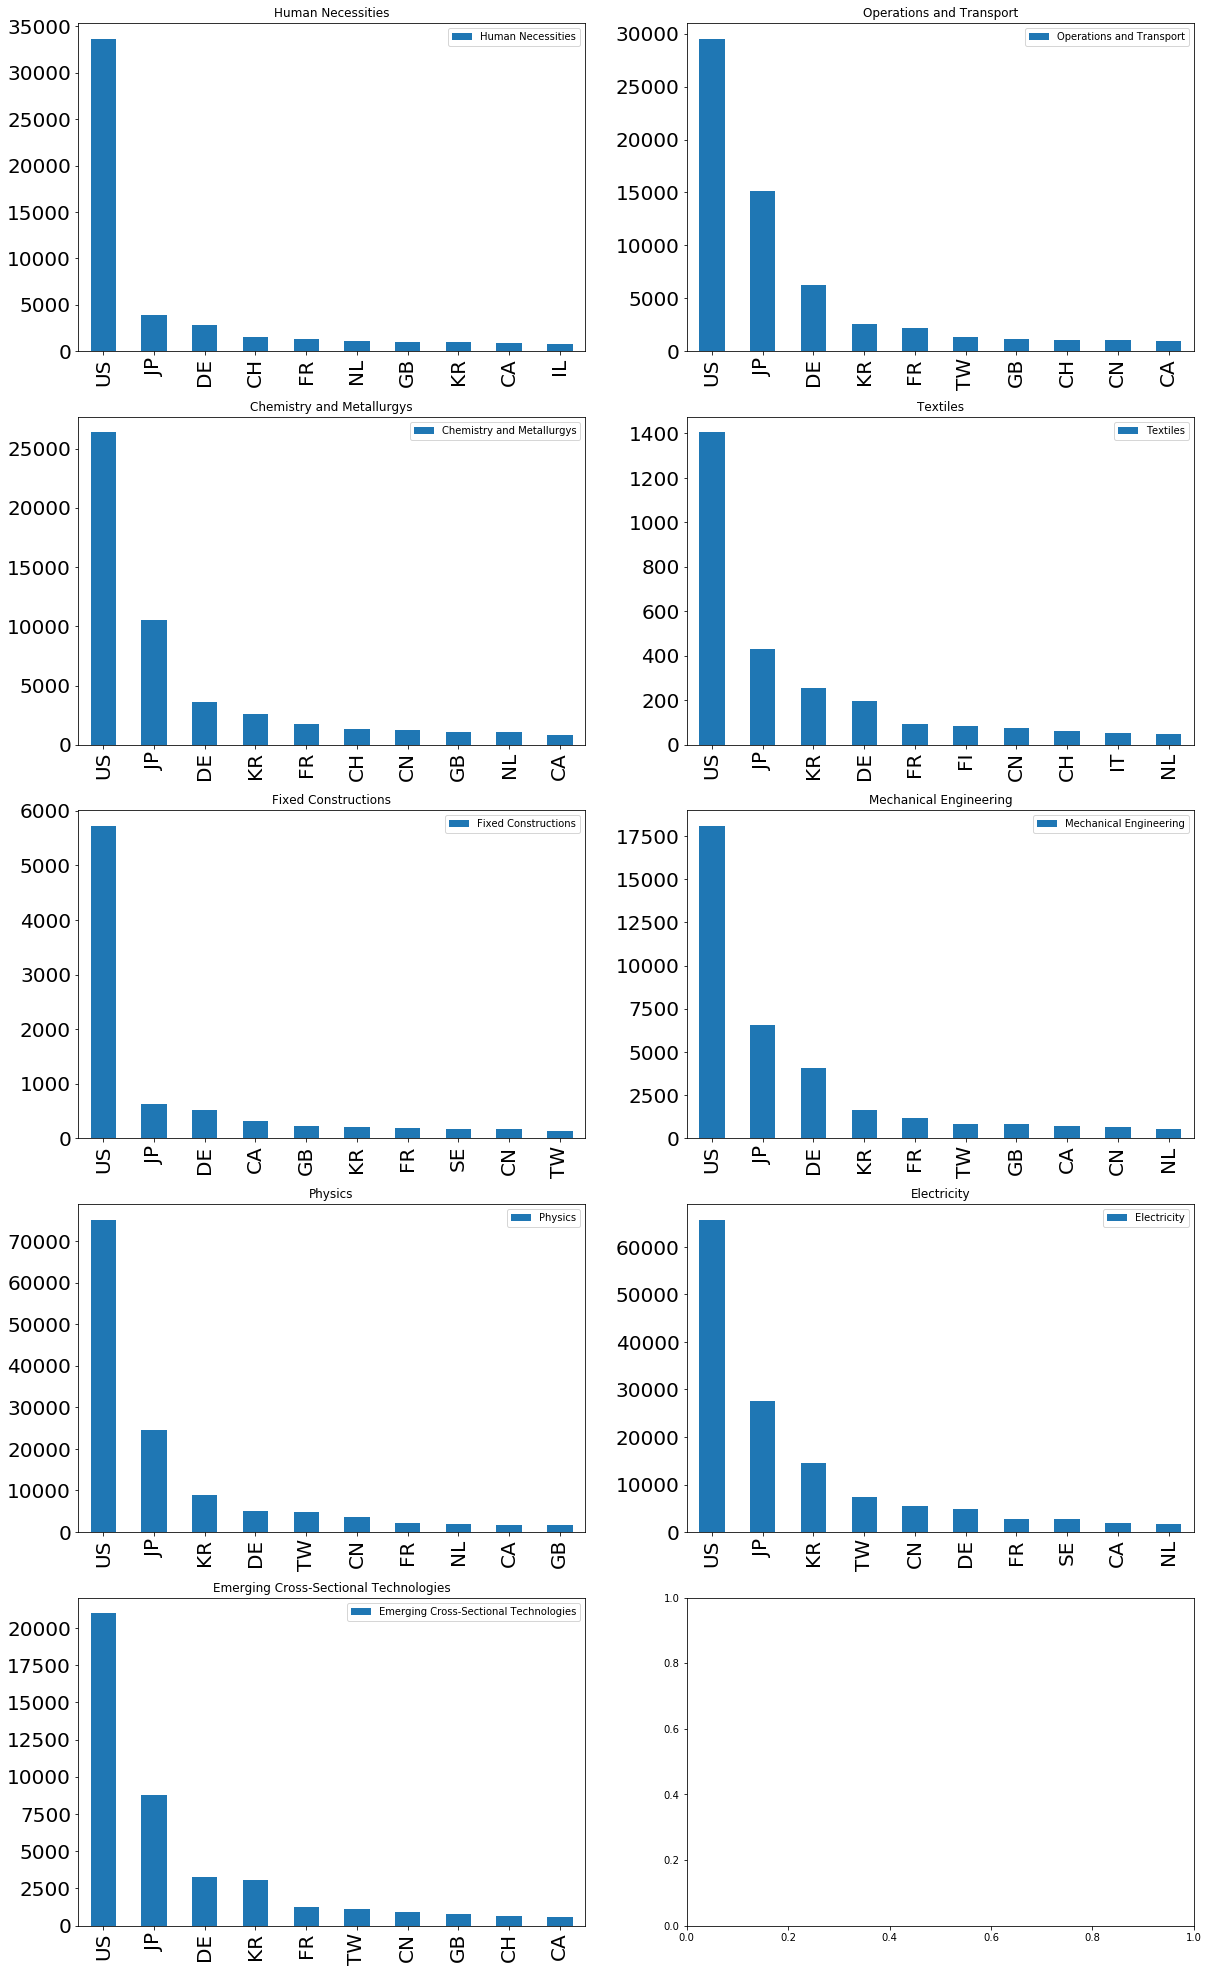

In [42]:
#This function plot one country, it takes as parameter the category ('A','B','C',...),
#the label (Operations and Transport) and a tuple containing the index which indicate where is the
#plot located

#Label mapping
category_label = [('A', 'Human Necessities'),('B', 'Operations and Transport'),\
                  ('C', 'Chemistry and Metallurgys'),('D', 'Textiles'), ('E', 'Fixed Constructions'),\
                  ('F', 'Mechanical Engineering'),('G', 'Physics'),('H', 'Electricity'),\
                  ('Y', 'Emerging Cross-Sectional Technologies'),]
    
fix, axes = plt.subplots(5, 2, figsize=(20, 35))
for index, (category, label) in enumerate(category_label):
    fıgure_by_sector(category, label, (int(index/2), index%2), axes, patent_category_df)

An other way of visualizasing can be performed by plotting the number of patents by country and sector a a stacked bar chart.

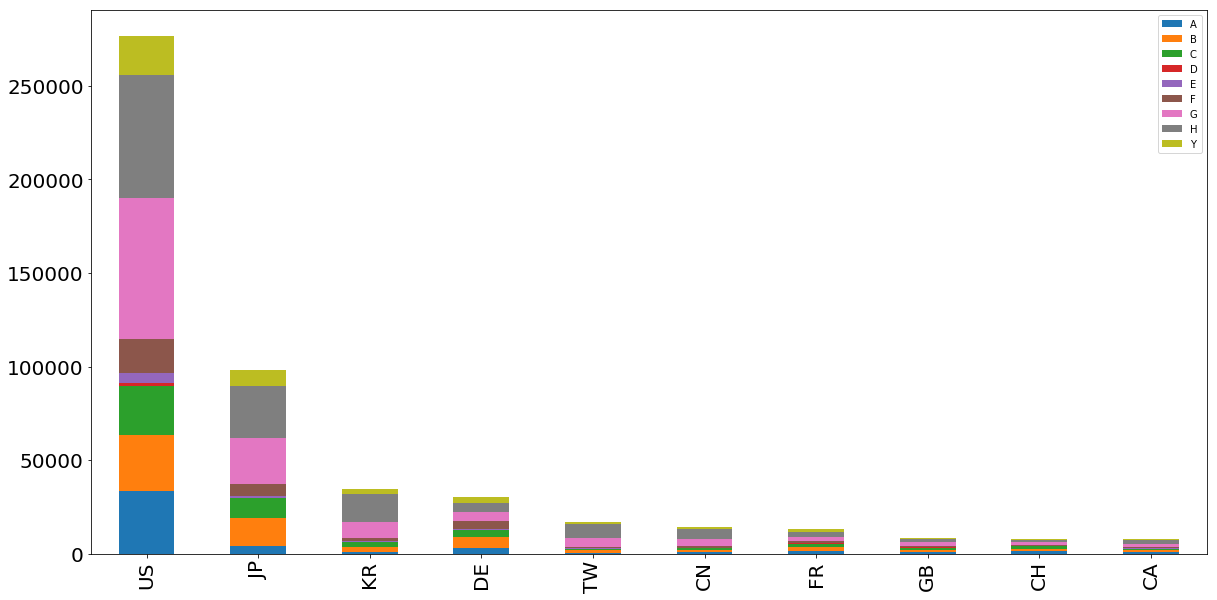

In [43]:
# Plot the TOP10 countries in terms of granted patents in a stacked bar chart
patent_category_df['total'] = patent_category_df.apply(sum, axis=1)
clean_df = patent_category_df.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,10));

As we can see, the United States is the leader country in all sectors. Japan also has also a significant number of patents in terms of sectors G and H. Other countries as Germany (DE), South Korea (KR), Taiwan (TW), France (FR), Netherlands (NL), Switzerland (CH), China (CN) and United Kingdom (GB) comes next with less significant number of patents.

### Spider charts modeling the different patent sectors in different countries

This function sorts the DataFrame containing the categorized patents for each country, by the given column passed as a parameter.

In [44]:
def sortby(col):
    return cat_patent.sort_values(by=col, ascending=False)

As an example, this DataFrame represents the TOP5 countries in europe in terms of sector A, which is Human Necessities.

In [45]:
cat_patent = pd.DataFrame(country_total_patent_category).transpose()
sortby('A').head()

,A,B,C,D,E,F,G,H,Y
US,33672.0,29529.0,26365.0,1405.0,5722.0,18081.0,75174.0,65754.0,20987.0
JP,3918.0,15127.0,10491.0,432.0,638.0,6556.0,24593.0,27602.0,8762.0
DE,2767.0,6205.0,3649.0,197.0,518.0,4048.0,5038.0,4863.0,3255.0
CH,1548.0,1089.0,1309.0,60.0,107.0,540.0,1522.0,1118.0,629.0
FR,1353.0,2223.0,1793.0,95.0,184.0,1172.0,2252.0,2652.0,1258.0


After some examining different countries around the world, we decided to choose 9 of them, which are quite different between one another in terms of granted patents distribution across the sectors. For this task, we considered the *United States, Japan, Germany, Canada, Switzerland, France, the Netherlands, Great Britain* and *Korea*.

We will now display a spider chart for each one of them. The function **spider_chart** takes care of this task. It shows the involvment level of a given country in all the 7 sectors in CPC (Cooperative Patent Classification) by modeling the relative number of granted patents for each sector, country-wise.

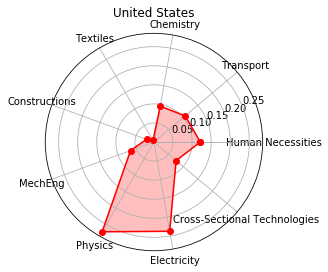

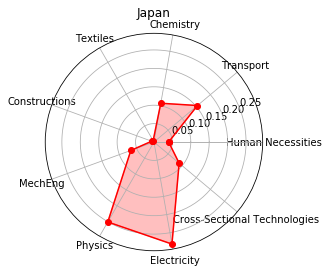

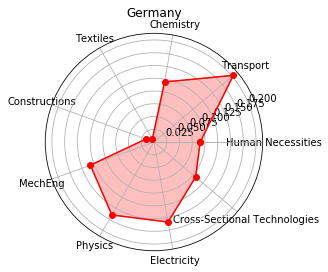

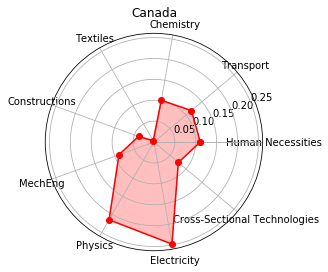

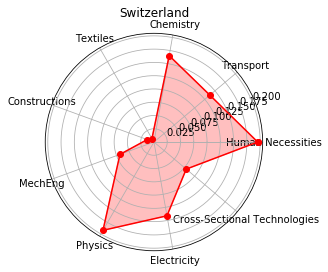

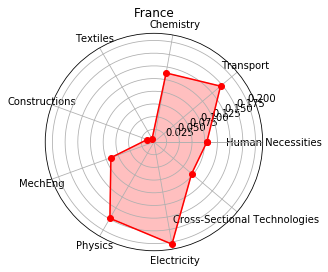

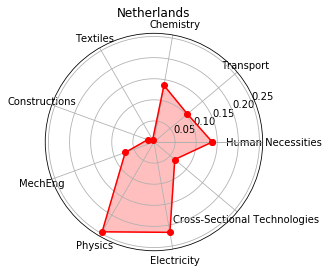

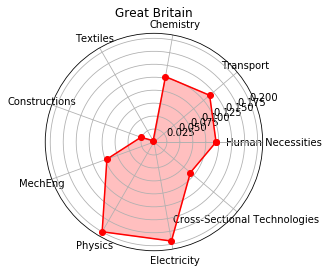

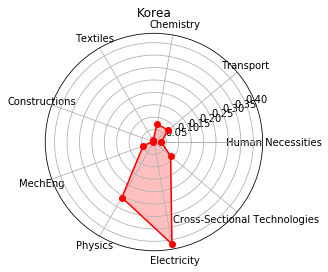

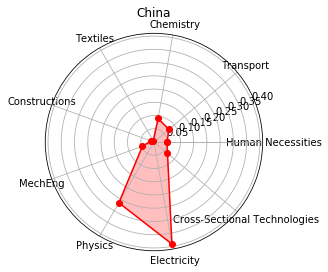

In [46]:
model_countries = [('US', 'United States'),('JP', 'Japan'), ('DE','Germany'), ('CA','Canada'),\
                   ('CH', 'Switzerland'), ('FR','France'), ('NL','Netherlands'), \
                   ('GB','Great Britain'), ('KR', 'Korea'), ('CN', 'China')]
    
model = sortby('A').head(15)
model = model.apply(lambda x: x/sum(x), axis=1) # Normalizing the number of patents per sector to extract percentage rates(%)

for i in range(len(model_countries)):
    spider_chart(model, model_countries[i][0], title= model_countries[i][1])

We can see that Japan, Korea, China, Great Britain France and the United States hold most of their patents in the Electricity and the Physics sectors. Switzerland's patents are more concentrated on Chemistry, Humans Necessities and Physics. Germany, Switzerland and Great Britain hold significant number of patents in Transport. 

In overall, Germany, Switzerland and Great Britain are the most polyvalent countries in terms of granted patent classifications, as we can see that they have the most diversified patents across the different sectors.

### Evolution of granted patents for a given sector

This last part aims to study the evolution of granted patents per sector of interest. This section will be done mostly for milestone 3.

As a brief overview, the evolution of patents in solar energy was carried out. At the end, this evolution will be compared with the aggregated evolution of patents (in every sector). This study will be useful for comparisons between different technologies in energy. 

The keywords used are given in the *paper* **"Patent-based Technology report - Alternative Energy Technology"** made by the **"World Intellectual Property Organization"**, which gives a fairly accurate result for energy technologies. The keywords are used to search for a match in the patent titles.  

In [ ]:
Keywords_Solar_Power= ["solar cell", "solar-cell","photovoltaic", "solar photo", "PV sun", "light cell",
"panel module"] 

The function **get_patents_keywords** returns the number of patents in a given year according to a list of key words at a given year.

This function also returns a dataframe containing 25 samples maximum of every patent related to a keyword (for checking sake)

In [ ]:
list_patent_nb_solar=[]
years= range(2007,2017)
for i in years:
    [dfPatent, nb_patent]=get_patents_keywords(Keywords_Solar_Power,str(i))
    list_patent_nb_solar+=[nb_patent]

Plot the evolution of number of patent between year 2007 and 2017

In [ ]:
plt.plot(years,list_patent_nb_solar)
plt.ylabel('Number of patents')
plt.title('Evolution of patents related to solar technologies')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

The evolution of granted patent in solar energy can be compared with the aggregated evolution of granted patent for the past 10 years. In order to achieve this pupose, we can compute the growth of patents per year according to the folowing formula :

\begin{equation*}
Growth  = \frac{nb\ patents\ year\ i+1\ -\ nb\ patents\ year\ i}{nb\ patent\ year\ i}
\end{equation*}




In [ ]:
growth_solar=[]
growth=[]
list_nb_patent=list(df_nb_patent['nb_patents'])
for i in range(len(years)-1):
    growth_solar+=[(list_patent_nb_solar[i+1]-list_patent_nb_solar[i])/list_patent_nb_solar[i]*100]
    growth+=[(list_nb_patent[i+1]-list_nb_patent[i])/list_nb_patent[i]*100]

We plot the growth rate of the solar technology patents, compared to the average growth of patents across all sectors.

In [ ]:
plt.plot(range(2008,2017),growth_solar,range(2008,2017),growth)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Relative growth of patents")
plt.legend("solar energy patents","general patents")
plt.ylabel('Growth rate %')
plt.show()

**The blue graph represents the growth of the solar technology related patents, and in orange the growth of patents in general**

It can be observed that the patents granted in solar technology had a significant growth between 2008 and 2013 compared to the other technologies.

# Patents in the Energy Sector

In [3]:
from implementations import *

In [2]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
years=range(2007,2017)
list_ipc_solar_p=[('E','04','13'),('H','01','25'),('H','01','31'),('H','02','6')]

keywords_solar_power= [["solar", "cell"], ["solarcell"],["solar-cell"],["photovoltaic"], ["solar", "light"], 
                       ["solar", "panel"],["solar", "module"],["photo", "light"],["photo", "cell"],
                       ["photo", "panel"],["photo", "module"],["PV", "light"], ["PV", "cell"],
                       ["PV", "panel"],["PV", "module"],["sun", "light"],["sun", "cell"],
                       ["sun", "panel"],["sun", "module"]] 


keywords_solar_thermal=[['CSP'],['concentrat'],['trough'],['dish'],['tower'],['sterling'],
                        ['stirling'],['solar','heat'],['solar','thermal'],['solar','accumulate'],
                        ['solar', 'boiler'],['solar','house'],['solar','hot'],['solar','building'],
                        ['solar','system'],['solar', 'boiling'],['sun','heat'],['sun','thermal'],
                        ['sun','accumulate'],['sun', 'boiler'],['sun','house'],['sun','hot'],
                        ['sun','building'],['sun','system'],['sun', 'boiling']]

keywords_wind=['wind','turbine']

keywords_hydro = [['hydropower'], ['hydroelectric'], ['hydro-electr'], ['hydro-power'], 
                  ['water-power'],['waterpower'], ['flow'], ['fluid'], ['fluidpressure'], 
                  ['dam'], ['hydro'],['water'], ['river'], ['drainag'],  ['hydraulic'], 
                  ['buoyancy'], ['tunnel','pump'],['pelton','turbine'], ['turgo','turbine'], 
                  ['ossberger','turbine'], ['fransis','turbine'],['kaplan','turbine'],
                  ['tubular','turbine'], ['bulb rim','turbine']]

keywords_wave_and_tidal = [['tidal'], ['tide'], ['seawater'], ['sea','water'], 
                           ['ocean'],['wave'], ['bollow'], ['offshore'], ['onshore'], 
                           ['duck'], ['float'],]

keywords_carbon_capture_and_storage = [['carbon','dioxide','storage'], ['carbon','dioxide','capture'], 
                ['carbon','dioxide','recover'],['carbon','dioxide','deliver'],['carbon','dioxide','regenerat'], 
                ['co2','storage'], ['co2','captur'], ['co2','recover'],['co2','deliver'],['co2','regenerat'],
                ['carbon','gas','storage'], ['carbon','gas','captur'], 
                ['carbon','gas','recover'],['carbon','gas','deliver'],['carbon','gas','regenerat']]

keywords_coal_and_gas=[['gas'],['carbon'],['monoxide'],['steam','engine'],['steam','generation'],
                       ['steam','machine'],['combustion'],['burner'],['furnace'],['coal']]

keywords_nuclear = [['control','nuclear'],['nuclear','reaction'],['nuclear','plant'],
                   ['nuclear','reactor'],['nuclear','explosion'],['magnetic','resonance'],
                   ['plasma'],['fission'],['particule'],['fusion']]

list_ipc_solar_t=[('F','03','6'),('G','02','5'),('H','01','31'),('C','02','1'),
                  ('E','04','13'),('F','02','1'),('F','22','1'),('F','24','9'),('F','24','1'),
                  ('F','24','2'),('F','24','3'),('F','25','27'),('F','26','3'),('H','02','6')]

list_ipc_wind=[('F','03','1'),('F','03','3'),('F','03','5'),('F','03','7'),('F','03','8'),
               ('F','03','9'),('F','03','13'),('F','03','15'),('F','03','17'),('F','03','80'),
               ('B','60','8')]

list_ipc_hydro=[('E','02','9'),('F','03','1'),('F','03','3'),('F','03','7'),('F','03','13'),
               ('F','03','15'),('F','03','17'),('F','16','41'),('H','02','57')]

list_ipc_wave_and_tidal=[('E','02','9'),('F','03','7'),('F','03','13'),
               ('F','03','15'),('F','03','17')]

list_ipc_carbon_capture_and_storage=[('B','63','35'),('C','01','3'),('C','01','31'),
               ('C','02','1'),('C','07','7'),('F','01','3'),('F','25','3'),('B','01','20'),
               ('B','01','53'),('B','01','11')]

list_ipc_carbon_coal_and_gas=[('C','10','1'),('C','10','3'),('F','01','1'),
               ('F','01','2'),('F','01','5'),('F','01','7'),('F','01','9'),('F','01','11'),
               ('F','01','17'),('F','22','5'),('F','22','7'),('F','22','9'),
               ('F','23','10'),('F','23','20'),('F','23','30'),('F','23','40'),('F','23','50'),
               ('F','23','60'),('F','23','80'),('F','23','1'),('F','23','3'),('F','23','5'),
               ('F','23','7'),('F','23','9')]

list_ipc_nuclear=[('G','21','1'),('G','21','3'),('G','21','5'),
               ('G','21','7'),('G','21','17'),('G','21','19'),('G','01','24'),('H','05','6')]

In [ ]:
list_nb_patent_solar_p, _= get_nb_patent_years_keyword(years,keywords_solar_power,list_ipc_solar_p)
list_nb_patent_solar_t, _ = get_nb_patent_years_keyword(years, keywords_solar_thermal, list_ipc_solar_t)
list_nb_patent_wind, _ = get_nb_patent_years_keyword(years,keywords_wind,list_ipc_wind)
list_nb_patent_hydro, _ = get_nb_patent_years_keyword(years,keywords_hydro,list_ipc_hydro)
list_nb_patent_wave_tidal, _ = get_nb_patent_years_keyword(years,keywords_wave_and_tidal, list_ipc_wave_and_tidal)
list_nb_patent_carbon_capture_and_storage, _= get_nb_patent_years_keyword(years, 
                keywords_carbon_capture_and_storage, list_ipc_carbon_capture_and_storage)
list_nb_patent_coal_and_gas, _ = get_nb_patent_years_keyword(years,
                    keywords_coal_and_gas, list_ipc_carbon_coal_and_gas)
list_nb_patent_nuclear, _ = get_nb_patent_years_keyword(years,
                    keywords_nuclear, list_ipc_nuclear)

In [ ]:
dfEvolutionPatent=pd.DataFrame(columns=['solar photo','solar therm','wind','hydro',
                        'tidal and wave','carbon capture','coal and gas','nuclear energy'])
dfEvolutionPatent=dfEvolutionPatent.reindex(list(years))
dfEvolutionPatent['solar photo']=list_nb_patent_solar_p
dfEvolutionPatent['solar therm']=list_nb_patent_solar_t
dfEvolutionPatent['wind']=list_nb_patent_wind
dfEvolutionPatent['hydro']=list_nb_patent_hydro
dfEvolutionPatent['tidal and wave']=list_nb_patent_wave_tidal
dfEvolutionPatent['carbon capture']=list_nb_patent_carbon_capture_and_storage
dfEvolutionPatent['coal and gas']=list_nb_patent_coal_and_gas
dfEvolutionPatent['nuclear energy']=list_nb_patent_nuclear

In [ ]:
savedfexcel(dfEvolutionPatent,'evolution_nb_patents')

In [4]:
dfNbPatent=pd.read_excel('evolution_nb_patents.xlsx')

dfNbPatent['renewable']=dfNbPatent[['solar photo','solar therm','wind','hydro','tidal and wave',
                                   'carbon capture']].sum(axis=1)
dfNbPatent

,solar photo,solar therm,wind,hydro,tidal and wave,carbon capture,coal and gas,nuclear energy,renewable
2007,44,19,192,33,7,2,328,19,297
2008,36,15,204,36,14,2,309,17,307
2009,59,29,188,22,17,5,269,26,320
2010,139,48,303,49,19,9,394,28,567
2011,222,87,484,93,30,12,370,23,928
2012,312,132,594,93,31,5,475,34,1167
2013,314,157,590,107,46,36,535,39,1250
2014,587,245,856,181,55,31,908,95,1955
2015,656,325,1036,216,54,33,1581,148,2320
2016,628,303,1116,237,56,42,1385,164,2382


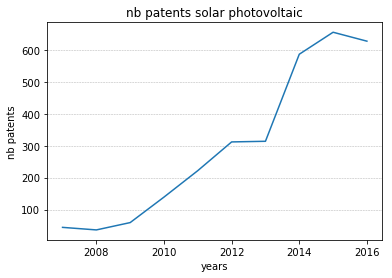

In [5]:
plt_nb_patent(years,dfNbPatent['solar photo'],'years','nb patents','nb patents solar photovoltaic')
plt.figure()

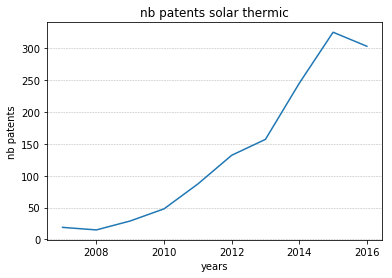

In [6]:
plt_nb_patent(years,dfNbPatent['solar therm'],'years','nb patents','nb patents solar thermic')
plt.figure()

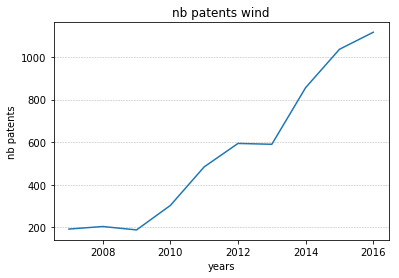

In [7]:
plt_nb_patent(years,dfNbPatent['wind'],'years','nb patents','nb patents wind')
plt.figure()

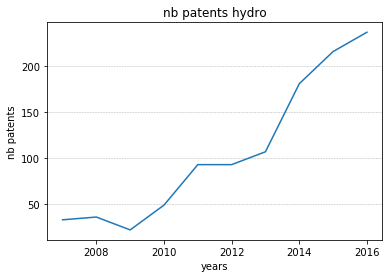

In [8]:
plt_nb_patent(years,dfNbPatent['hydro'],'years','nb patents','nb patents hydro')
plt.figure()

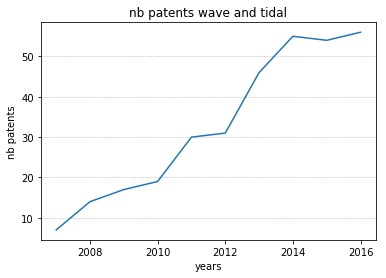

In [9]:
plt_nb_patent(years,dfNbPatent['tidal and wave'],'years','nb patents','nb patents wave and tidal')
plt.figure()

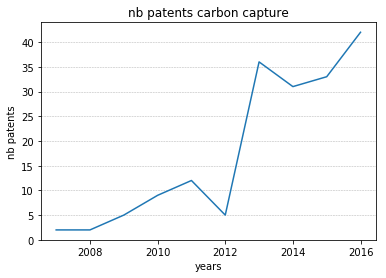

In [10]:
plt_nb_patent(years,dfNbPatent['carbon capture'],'years','nb patents', 'nb patents carbon capture')
plt.figure()

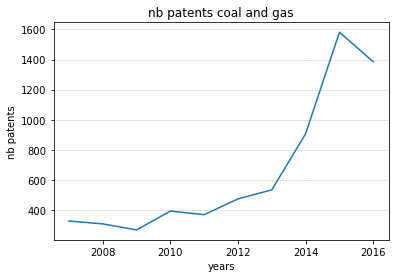

In [11]:
plt_nb_patent(years,dfNbPatent['coal and gas'],'years','nb patents','nb patents coal and gas')
plt.figure()

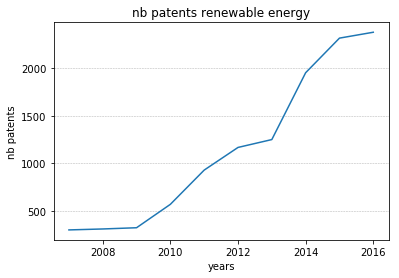

In [12]:
plt_nb_patent(years,dfNbPatent['renewable'],'years','nb patents','nb patents renewable energy')
plt.figure()

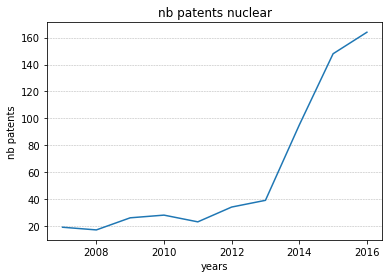

In [13]:
plt_nb_patent(years,dfNbPatent['nuclear energy'],'years','nb patents','nb patents nuclear')

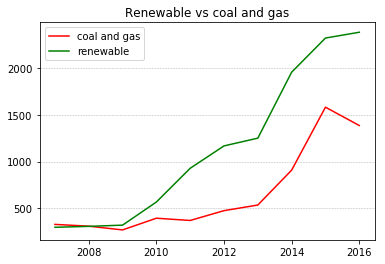

In [14]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(years, dfNbPatent['coal and gas'],'r', label='coal and gas')
ax.plot(years, dfNbPatent['renewable'],'g', label= 'renewable')
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.legend()
plt.title("Renewable vs coal and gas")

In [15]:
energies = ['solar photo','solar therm','wind','hydro', 'tidal and wave','carbon capture','coal and gas','nuclear energy']

dfEnergyPatentGrowth=pd.DataFrame(columns=['solar photo','solar therm','wind','hydro',
                        'tidal and wave','carbon capture','coal and gas','nuclear energy'])

for energy in energies:
    dfEnergyPatentGrowth[energy] = get_growth(years,list(dfNbPatent[energy]))

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

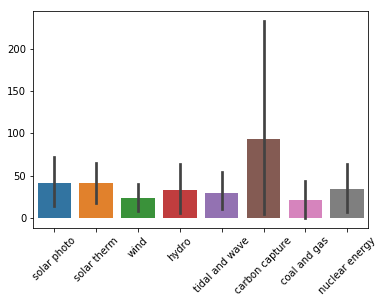

In [16]:
sns.barplot(data=dfEnergyPatentGrowth)
plt.xticks(rotation=45)

In [17]:
dfEnergyPatentGrowth.corr()

,solar photo,solar therm,wind,hydro,tidal and wave,carbon capture,coal and gas,nuclear energy
solar photo,1.000000,0.770742,0.708214,0.651853,-0.346187,-0.196159,0.376685,0.296973
solar therm,0.770742,1.000000,0.430283,0.256640,-0.332398,-0.077810,0.145474,0.274169
wind,0.708214,0.430283,1.000000,0.934295,-0.111408,-0.388760,0.438371,0.043223
hydro,0.651853,0.256640,0.934295,1.000000,0.008101,-0.144509,0.394091,-0.075878
tidal and wave,-0.346187,-0.332398,-0.111408,0.008101,1.000000,0.197868,-0.480574,-0.471622
carbon capture,-0.196159,-0.077810,-0.388760,-0.144509,0.197868,1.000000,-0.197049,-0.193649
coal and gas,0.376685,0.145474,0.438371,0.394091,-0.480574,-0.197049,1.000000,0.644984
nuclear energy,0.296973,0.274169,0.043223,-0.075878,-0.471622,-0.193649,0.644984,1.000000


In [18]:
years=list(range(2010,2017))

In [21]:
dfPatentSolarPhoto = build_dataframe(years,keywords_solar_power,list_ipc_solar_p)
dfPatentSolarThermo = build_dataframe(years,keywords_solar_thermal,list_ipc_solar_t)                                   
dfPatentWind = build_dataframe(years,keywords_wind,list_ipc_wind)  
dfPatentHydro = build_dataframe(years,keywords_hydro,list_ipc_hydro)  
dfPatentWaveTidal = build_dataframe(years,keywords_wave_and_tidal,list_ipc_wave_and_tidal)  
dfPatentCarbonStorage = build_dataframe(years,keywords_carbon_capture_and_storage,list_ipc_carbon_capture_and_storage)  

In [22]:
dfPatentRenewable=pd.concat([dfPatentSolarPhoto,dfPatentSolarThermo,dfPatentWind,
                   dfPatentHydro,dfPatentWaveTidal,dfPatentCarbonStorage], ignore_index=True)

In [23]:
# save individual dataframes
savedfexcel(dfPatentSolarPhoto, 'patent_solar_photo')
savedfexcel(dfPatentSolarThermo, 'patent_solar_thermo')
savedfexcel(dfPatentWind, 'patent_wind')
savedfexcel(dfPatentHydro, 'patent_hydro')
savedfexcel(dfPatentWaveTidal, 'patent_wave_tidal')
savedfexcel(dfPatentCarbonStorage, 'patent_carbon_storage')
# save the merged dataframe
savedfexcel(dfPatentRenewable,'patent_renewable')

In [19]:
# read
#dfNbPatent=pd.read_excel('evolution_nb_patents.xlsx')
dfPatentSolarPhoto = pd.read_excel('patent_solar_photo.xlsx')
dfPatentSolarThermo = pd.read_excel('patent_solar_thermo.xlsx')
dfPatentWind = pd.read_excel('patent_wind.xlsx')
dfPatentHydro = pd.read_excel('patent_hydro.xlsx')
dfPatentWaveTidal = pd.read_excel('patent_wave_tidal.xlsx')
dfPatentCarbonStorage = pd.read_excel('patent_carbon_storage.xlsx')
dfPatentRenewable = pd.read_excel('patent_renewable.xlsx')

In [20]:
# max_n is the maximum number of patents holder, which is the US
dfPatentRenewableMap = df_get_nb_by_group_and_clean(dfPatentRenewable,'inventor_country', years, True)
max_n = dfPatentRenewableMap['total'].max()
#Here, we set up a Colormap using the logarithmic scale as shades of Blue colors that will be used to color the map
colormap = cm.linear.PuBu.scale(0, round(math.log(max_n))).to_step(100)
#Take the log of the number of granted patents to match the logarithmic scale
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , dfPatentRenewableMap['total']))
#In the below DataFrame, each country has now its 'logarithmic color code'
dfPatentRenewableMap['log_color_code'] = log_nb
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = dfPatentRenewableMap['log_color_code']
#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

In [21]:
df_map=df_get_nb_by_group_and_clean(dfPatentRenewable,'inventor_country', years,True).reset_index().copy()
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = './data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors using our defined function ret_color, desribed above
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, max_n).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('patentsrenewable.html')

In [22]:
from ipywidgets import interact, interactive, fixed, interact_manual

interact(plt_interactive_by_country, sector=['solar photo','solar termal','wind','hydro','tidal and wave',
                                        'carbon capture','renewable'])

<function implementations.plt_interactive_by_country>

In [23]:
interact(plt_interactive_by_company, sector=['solar photo','solar termal','wind','hydro','tidal and wave',
                                        'carbon capture','renewable'])

<function implementations.plt_interactive_by_company>

# Patents in FinTech

We will now talk about the patents related to FinTech (financial technology).
First, let us introduce some keywords and IPCs that will allow us to search for these specific patents.

In [73]:
years = range(1976,2017)

ipc_fintech=[('G','06','30'),('G','06','-'), ('G', '06', '40'), ('H', '01', '21')]

keywords_fintech = [["cryptocurrency"], ["crypto","currency"],["crypto-currency"],["blockchain"], ["bitcoin"], 
                       ["distributed", "ledger"],["fintech"],["financial", "technology"],
                       ["virtual", "currency"],["virtual", "currencies"],["digital", "currency"], ["digital", "currencies"],
                       ["smart", "contracts"],["smart", "contract"], ["FinTech"], ['fintech'], ['financial'], ['financial','data'],
                       ['trading'], ['transaction'], ['transactions']]

The function **get_nb_patent_years_keyword** is similar to **get_nb_patents_year**, but filters the patents additionnaly by **IPC (International Patent Classification)**, which is a hierarchical classification system that classifies the patents into sections and classes. We are now able to look for the FinTech related keywords using our function.

In [74]:
fintech_number, fin_patents = get_nb_patent_years_keyword(years, keywords_fintech, ipc_fintech)

We are now able to plot the number of FinTech patents by year and visualize the growth. 

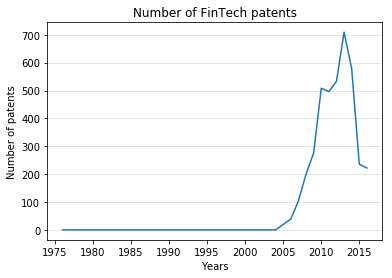

In [79]:
plt_nb_patent(years,fintech_number,'Years','Number of patents','Number of FinTech patents')
plt.figure()
plt.show()

We can see here that FinTech patents popped out recently in 2004 and went exponentially high to reach a peak of 709 patents in 2013.

Notice here that the number of patents almost doubled between 2009 and 2010 right after the introduction of Bitcoin, which was the start of a patent technology race for the cryptocurrency companies.

We will now perform some cleaning to our patents DataFrame. We extract the full names of the inventors by joining the first and last names, then we rename the columns.

In [56]:
fin = fin_patents.copy()
inventor_id_name = dict()
# Extracting the inventors first and last name
for row in fin["inventors"]:
    inventor_id = row[0]["inventor_id"]
    inventor_name = str(row[0]["inventor_first_name"]) + " " + str(row[0]["inventor_last_name"])
    inventor_id_name[inventor_id] = inventor_name

In [58]:
# Renaming the columns and formatting the date
fin.rename(columns={'patent_num_cited_by_us_patents': 'cited_by_others',}, inplace=True) 
fin["country"] = fin["assignees"].apply(lambda row: row[0]["assignee_country"])
fin["organization"] = fin["assignees"].apply(lambda row: row[0]["assignee_organization"])
fin["inventor_id"] = fin["inventors"].apply(lambda row: row[0]["inventor_id"])
fin["inventor_name"] = fin["inventor_id"].apply(lambda row: inventor_id_name[row])
fin["year"] = fin["patent_date"].apply(lambda row: int(row.split("-")[0]))
fin["month"] = fin["patent_date"].apply(lambda row: int(row.split("-")[1]))
fin["cited_by_others"] = fin["cited_by_others"].astype("int64")
fin.index = fin.patent_number

In [59]:
# Keep only the columns we're interested in
fin = fin.drop(axis = 1, labels=['IPCs','assignees', 'patent_date', 'patent_number', 'inventors', 'month'])

Here is what the result look like:

In [61]:
fin.head(3)

,patent_title,cited_by_others,country,organization,inventor_id,inventor_name,year
patent_number,,,,,,,
7158943,Marketing communication and transaction/distri...,108,None,None,7158943-1,Ramon van der Riet,2007
7175072,Strategies for handling transactions based on ...,2,US,Microsoft Corporation,5768515-2,Murali R. Krishnan,2007
7203657,General packet-based payment and transaction m...,5,None,None,7203657-1,Eli M. Noam,2007


Among those patents, we chose to display the 5 most cited ones, hence the most popular.

In [64]:
top_patents = fin.sort_values(by='cited_by_others', ascending=False)
top_patents = top_patents[["patent_title","cited_by_others", "year", "organization",\
                           "inventor_name", "country"]]

with pd.option_context('display.max_colwidth', -1):
    display(top_patents.head(5))

,patent_title,cited_by_others,year,organization,inventor_name,country
patent_number,,,,,,
7389268,Trading tools for electronic trading,282,2008,Trading Technologies International Inc.,Michael J. Burns,US
7228289,System and method for trading and displaying market information in an electronic trading environment,183,2007,Trading Technologies International Inc.,Harris C. Brumfield,US
7376603,Method and system for evaluating customers of a financial institution using customer relationship value tags,172,2008,Fair Isaac Corporation,Darcy Walker,US
7243083,Electronic spread trading tool,161,2007,Trading Technologies International Inc.,Mike Burns,US
7233922,System and method for wagering-based transferable financial instruments,159,2007,"Cantor Index, LLC",Howard W. Lutnick,US


Now, let us see who are the world first leaders among the FinTech patents inventors.

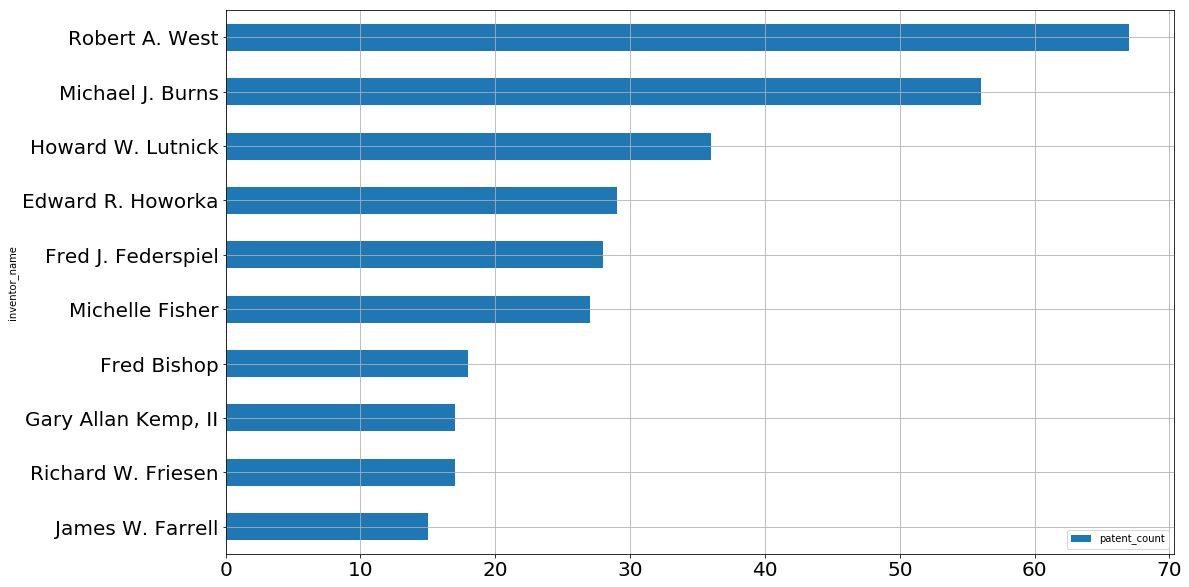

In [66]:
fin[["patent_title","inventor_id"]].rename(columns={'patent_title': 'patent_count',}, inplace=True)
fin["patent_count"] = 1
top_inventors = fin.groupby(['inventor_id']).sum().sort_values(by='patent_count', ascending=False)
        
top_inventors["inventor_name"] = top_inventors.index
top_inventors["inventor_name"] = top_inventors["inventor_name"].apply(lambda row: inventor_id_name[row])
top_inventors.head(10).plot.barh(x='inventor_name', y='patent_count', figsize=(17,10), fontsize=20, grid=True).invert_yaxis()

Funny story here is that **Robert A. West** holds the most patents in FinTech, what are the odds! After some googling it turned out that he was not our professor at all. As a matter of fact, Robert A. West is a intellectual property (IP) specialist who devoted his life to the creative process, and filing a large number of patents, 67 of which are FinTech related.

In [67]:
top_inventors.head(10)

,cited_by_others,year,patent_count,inventor_name
inventor_id,,,,
4417351-2,548,134762,67,Robert A. West
5224769-2,809,112623,56,Michael J. Burns
5905974-2,248,72405,36,Howard W. Lutnick
5806050-3,88,58332,29,Edward R. Howorka
7308428-1,335,56316,28,Fred J. Federspiel
8019365-1,189,54392,27,Michelle Fisher
6805287-1,120,36205,18,Fred Bishop
6766304-1,284,34188,17,"Gary Allan Kemp, II"
6993504-1,362,34195,17,Richard W. Friesen


As an example, here is one of his patents in FinTech:

In [68]:
list(fin[fin['inventor_name'] == 'Robert A. West'].patent_title)[0]

'System and method for calculating and displaying volume to identify buying and selling in an electronic trading environment'

Let us now know more about who issues the most FinTech patents among the firms worldwide. 

In [71]:
fin_org = fin.copy()
fin_org = fin_org[["patent_title","organization"]].rename(columns={'patent_title': 'patent_count',})
fin_org["patent_count"] = 1
top_organizations = fin_org.groupby(['organization']).sum().sort_values(by='patent_count', ascending=False)
top_organizations["organization"] = top_organizations.index
top_organizations.index = range(1,len(top_organizations)+1)

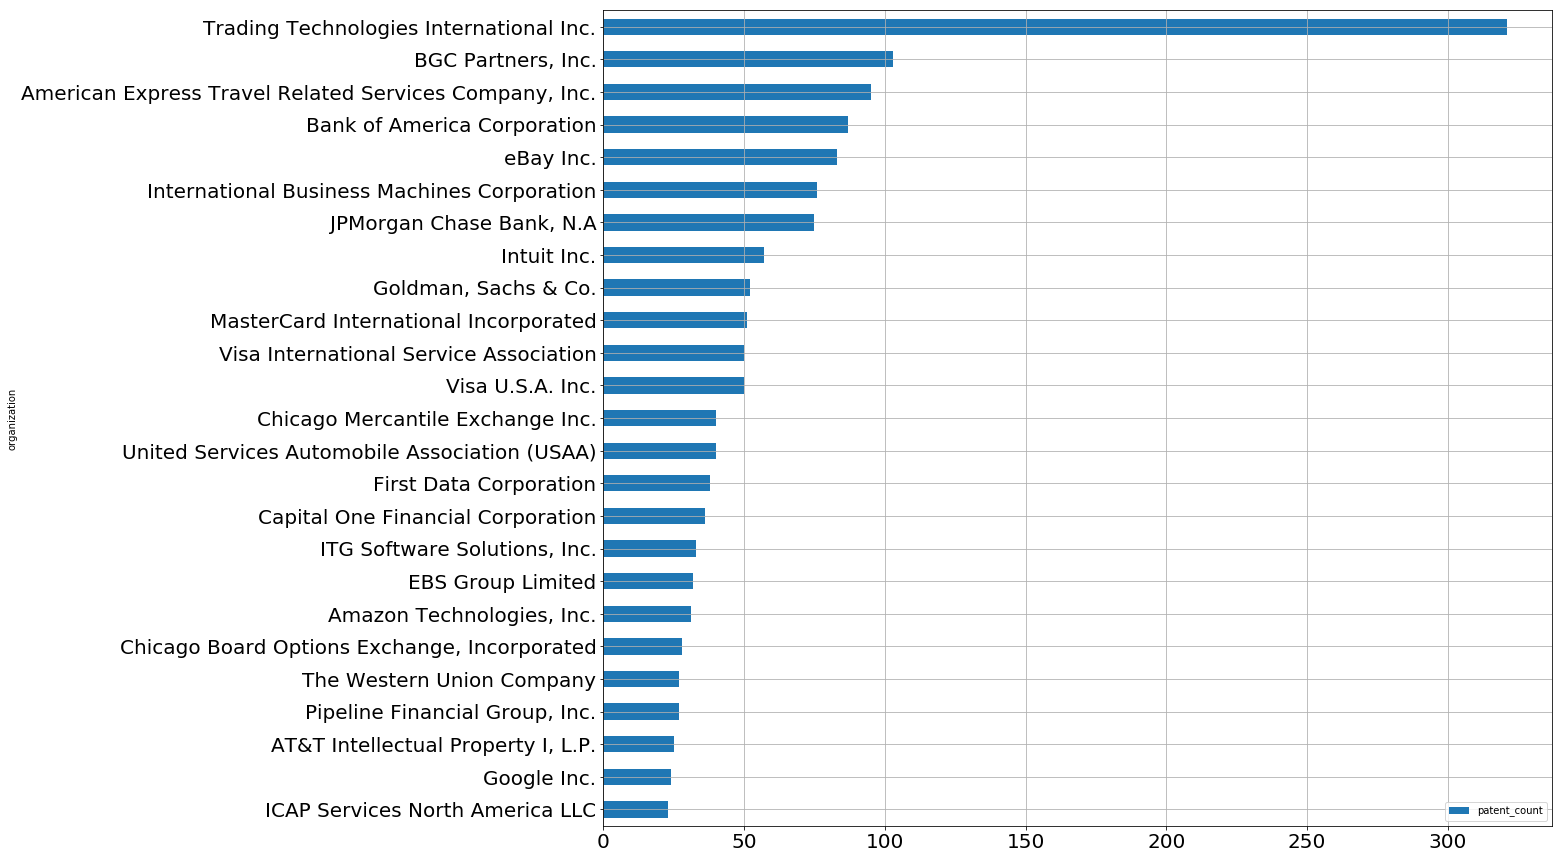

In [72]:
top_organizations.head(25).plot.barh(x ='organization', y= 'patent_count',figsize=(17,15),\
                                     fontsize=20, grid= True).invert_yaxis()

Trading Technologies International Inc. is a Chicago based company that develops and delivers professional trading software platforms for trading around the world. It takes the lead of FinTech patents by issuing about 350 patents so far. Among the known companies, American Express ranks 3rd, eBay 5th, IBM 6th and VISA 11th.

Let us now talk more about the firms who issue the blockchain patents.
For this need we scrapped the Clarivate Analytics database, which is an independent company that owns and operates a collection of patents, seeking the first world issuers of blockchain patents. We came up with the following firms:

In [76]:
#From Clarivate Analytics 
blockchain = pd.read_csv('./data/blockchain.csv')
blockchain.index = range(1, len(blockchain)+1)
blockchain

,Company,Blockchain patents,Industry
1,SECURITY FIRST CORP,64,IT
2,MICROSOFT,40,IT
3,IBM,25,IT
4,QUALCOMM,19,Semiconductor
5,TORONTO DOMINION BANK,19,FinTech
6,MASTERCARD,15,FinTech
7,SCALITY SA,13,IT
8,MEDICI INC,10,Blockchain
9,GOOGLE,9,IT
10,FUJITSU,9,IT


Security First Corp. takes over the blockchain patent field (64). The interesting part here is that IT, Semiconductor and Telecommunication companies are also involved in the blockchain patents, even though it’s not particularly their chosen field. 

Let us draw a bar chart for a better visualization:

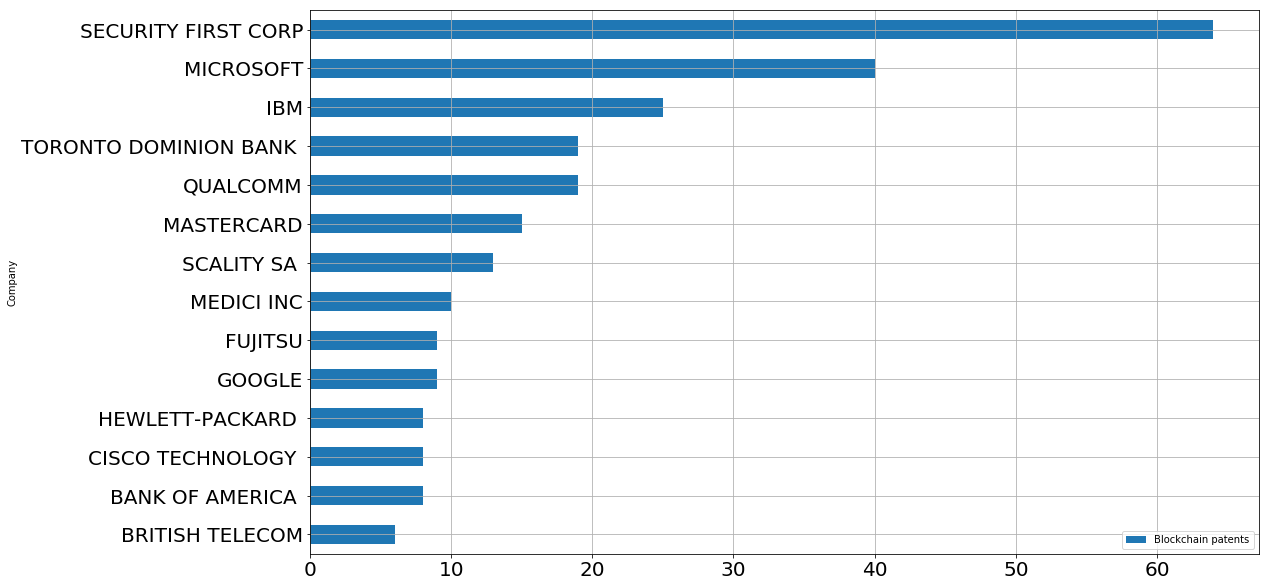

In [77]:
blockchain.sort_values(by='Blockchain patents', ascending = True).head(20).plot.barh(x='Company', y='Blockchain patents', figsize=(17,10), fontsize=20, grid=True)
plt.show()

We can identify some famous firms such as Microsoft who ranks 2nd, IBM 3rd, MasterCard 6th and Google 10th.

We will now classify all the FinTech patents by country and try to give an overview on the world distribution of the FinTech patents.

In [87]:
# Dictionary for to store the countries with their respective number of Fintech patents
fin_patent_by_country = dict()
for country in fin.country.unique():
    fin_patent_by_country[country] = dict()
    for i in range(2018-1976):
        year = 1976+i
        if year != 2005 and year != 2017:
            fin_patent_by_country[country][year] = int()

# Perform the count
for country, year in zip(fin["country"], fin["year"]):
    if year != 2005 and year != 2017:
        fin_patent_by_country[country][year] += 1

# Clean the dictionary
del fin_patent_by_country[None]
del fin_patent_by_country["City of\""]

In [92]:
# Build a dataframe from the dictionary and a flip the axes
country_year_df =\
pd.DataFrame([(country,year,value) for country,v in fin_patent_by_country.items() for year,value in v.items()],\
             columns = ['country','year','patent_num'])
country_year_df = country_year_df.pivot(index='country', columns='year', values='patent_num')
country_num = pd.DataFrame(country_year_df_copy["total"])

**country_year_df** is a dataframe that contains countries in rows, and years in columns from 1976 to 2016, and each entry represents the number of FinTech patents for a given country at a given year.

Here below we sum up each row to retrieve the cumulative number of patents since 1976.

In [93]:
country_year_df_copy = country_year_df.copy()
country_year_df_copy['total'] = country_year_df_copy.apply(sum, axis=1)
clean_df = country_year_df_copy.sort_values(by='total', ascending=False).drop('total',axis=1)

Let's now draw a world map to visualize the world distribution of the FinTech patents:

In [94]:
# Define a colormap and max_count for the map legend
max_count = country_num['total'].max()
colormap = cm.linear.PuBu.scale(0, round(math.log(max_count)))
log_total = list(map(lambda x: math.exp(math.log(x)) if (x > 0) else 0 , country_num['total']))
country_num['log_total'] = log_total

In [96]:
# Helper function to map colors to the countries
def get_color(feature, colors):
    if (feature['properties']['iso_a2'] in colors.keys()):
        return colors[feature['properties']['iso_a2']]
    else:
        return '#ffffff' 

In [ ]:
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = country_num.drop(axis = 1, labels=['total'])

#In the DataFrame, each country has now its own "color code"
patents_dict = patents_dict["log_total"]

#Here we map each country to a color according to the number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

In [ ]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = 'data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))


#Apply the colors using our defined function ret_color, desribed above
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': get_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, max_count).to_step(50)
colormap.caption = 'Number of FinTech Patents'
m.add_child(colormap)

#Save to HTML map
m.save('data/fintech_world.html')

Here is an overview of the distribution of FinTech granted patents over the world 

**The interactive map can be accessed [here](https://skagankose.github.io/ada_fall_2017/html/fintech_world.html).**

![Image](data/fintech_world.png)

We can easily spot the countries that has most FinTech patents in dark blue, and this also includes Switzerland!

Let us now talk about a specific technology of FinTech which is e-banking, a method of banking in which the customer conducts transactions electronically via the Internet.

For this task, we scrapped **Google Patents** to retrieve the e-banking related patents.

In [121]:
# Google Patents
e_banking = pd.read_csv('./data/e-banking.csv', encoding = "ISO-8859-1").dropna()
e_banking.set_index(pd.Series(range(1, len(e_banking) + 1)), inplace=True)
# Cleaning
clean_e_banking = e_banking.drop(\
            labels=['id', 'priority date', 'filing/creation date', 'publication date', 'result link'], axis=1)

Here is a small overview on the e-banking dataFrame.

In [122]:
clean_e_banking.head()

,title,assignee,inventor/author,grant date
1,Cash dispensing automated banking machine with...,Diebold Self-Service Systems Division Of Diebo...,"Natarajan Ramachandran, Ashok Modi, Jeff Hill,...",1/27/09
2,Method and system for remote delivery of retai...,Online Resources & Communications Corp.,"Matthew P. Lawlor, Timothy E. Carmody",7/11/06
3,Method and system for remote delivery of retai...,"Online Resources, Ltd.","Matthew P. Lawlor, Timothy E. Carmody",6/15/93
4,Electronic-monetary system,"Citibank, N.A.",Sholom S. Rosen,9/26/95
5,Data transaction assembly server,"Cyber Fone Technologies, Inc.",Rocco L. Martino,3/28/00


If we sort these patents by company, we can rank them by assignee (company).

Here is the top 20 of the world issuers of e-banking related patents.

In [123]:
clean_e_banking['Number of e-Banking patents'] = 1
clean_e_banking.groupby('assignee').sum().sort_values(by= 'Number of e-Banking patents', ascending=False).head(20)

,Number of e-Banking patents
assignee,
"Citibank, N.A.",14
"Diebold, Incorporated",12
"Diebold Self-Service Systems Division Of Diebold, Incorporated",8
Microsoft Corporation,7
Island Intellectual Property Llc,6
Intertrust Technologies Corp.,6
"Hitachi, Ltd.",5
"Transaction Technology, Inc.",5
"Verifone, Inc.",5


**Citibank** takes the lead in e-banking with 14 patents. 

In 2015, Citibank was the first firm to introduce the **Passwordless Security**. As a matter of fact, the bank was granted a patent for a system allowing users to log into an online account via a trusted device (computer, smartphone, tablet, etc.). 

**Diebold** who ranks 2nd, is an American financial self-service, security and services corporation internationally engaged primarily in the sale, manufacture, installation and service of self-service transaction systems such as ATMs

We will now sort the e-banking patents by year to see how they evolved

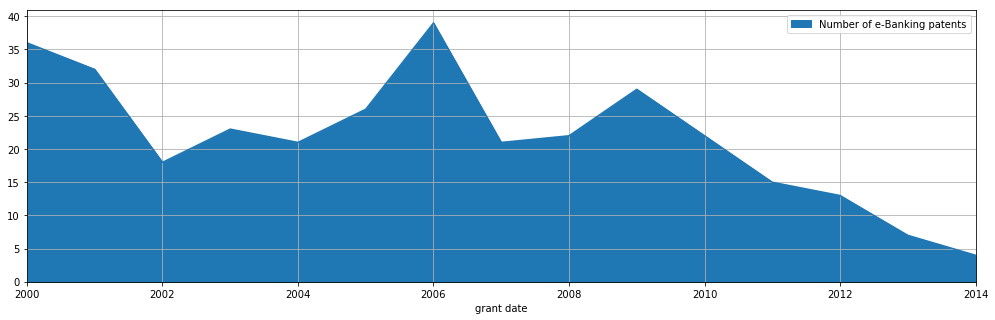

In [124]:
clean_e_banking['grant date'] = clean_e_banking['grant date'].\
        apply(lambda x: ("19" + x.split('/')[2]) if (int(x.split('/')[2]) > 50) else ("20" + x.split('/')[2]))
top_e_banking = clean_e_banking.groupby('grant date').sum().sort_index()
plot_e = top_e_banking.loc['2000':]
plot_e.plot(y = 'Number of e-Banking patents', figsize=(17,5), grid=True, kind='area')

From the above plot, we can see that from 2004 to 2006, there has been a lot considerably important interested in the e-banking. During this period, a lot of banks around the worlds developped their e-banking platforms, in particular mobile bankings apps, which explains the increase in the patents. Afterwards when e-banking became mainstream and well developped, we can observe a decrease in the number of patents, which reflects that once e-banking was implemented by almost every bank, there was no additional need to issue more of these patents. Notice once again, that from 2009 there was a significantly decrease of patents when the blockchain technology was born and took over all the FinTech patents. 